In [1]:
%run ../confg

In [2]:
"""Script to read in Hobos data
Subset the original Dataset to our time, and save it as hobos_final.nc

Plot also the station locations, I have defined some stations on the north slope of Innsbruck (to get the vertical)
"""
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import xarray as xr
from adjustText import adjust_text
from rasterio.plot import show

In [12]:
def subset_hobos():
    """Function used to cut hobos minute observations to the desired time frame"""
    df_hobos = xr.open_dataset(data_folder + "201710_hobo.nc")
    df_hobos["TIME"] = df_hobos["time"]
    df_hobos = df_hobos.drop_vars("time")
    df_hobos_subset = df_hobos.sel(TIME=slice('2017-10-15T14:00:00', '2017-10-16T12:00:00'))

    df_hobos_subset.to_netcdf(data_folder + "hobos_final.nc")
    #return df_hobos_subset

In [13]:
def locations_plot():
    """Plot the locations (lat, lon) of the hobos stations with improved visuals."""
    data = xr.open_dataset(data_folder + "HOBO/hobos_final.nc")
    dem = rasterio.open(TIROL_DEMFILE)
    station_keys = [14, 15, 16, 17, 18, 19, 20, 38, 39, 40, 41, 42, 43, 44, 45]
    station_keys_right = np.add(station_keys, -1)

    # Creating the plot
    fig = plt.figure(figsize=(20, 15))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([11.33, 11.49, 47.2380, 47.3190], crs=ccrs.PlateCarree())

    # Display DEM with an aesthetic color map
    retted = show(dem, ax=ax, cmap='terrain', contour=False, transform=ccrs.PlateCarree())
    im = retted.get_images()[0]

    # Calculate altitude limits
    altitudes = []
    for i in range(len(data['lon'])):
        row, col = dem.index(data['lon'][i], data['lat'][i])
        altitude = dem.read(1)[row, col]
        altitudes.append(altitude)

    min_alt = min(altitudes)
    max_alt = max(altitudes)
    im.set_clim(min_alt, max_alt)
    cbar = fig.colorbar(im, ax=ax, orientation='vertical')
    cbar.set_label('Altitude (m)')

    # Add geographical features
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1)

    # Plot stations with distinct colors and size adjustments
    scatter = ax.scatter(data['lon'], data['lat'], color='deepskyblue', s=100, edgecolor='black',
                         label='HOBOS Stations', transform=ccrs.PlateCarree())

    highlighted_lons = data['lon'].sel(STATION_KEY=station_keys_right)
    highlighted_lats = data['lat'].sel(STATION_KEY=station_keys_right)
    ax.scatter(highlighted_lons, highlighted_lats, color='red', s=150, edgecolor='black', label='Nord Stations',
               transform=ccrs.PlateCarree())

    # Text annotations with optimized visibility
    texts = []
    bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="none", alpha=0.8)
    for i, txt in enumerate(data['STATION_KEY']):
        text = ax.text(data['lon'][i], data['lat'][i],
                       f'{data["hobo_id"][i][0].values} ({int(data["zsl"][i].values)}m)',
                       fontsize=10, fontweight='bold', bbox=bbox_props, transform=ccrs.PlateCarree())
        texts.append(text)
    adjust_text(texts, expand_text=(1.2, 1.5))

    # Gridlines and labels enhancements
    gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False

    plt.scatter(station_files_zamg["IAO"]["lon"], station_files_zamg["IAO"]["lat"], label="Innsbruck UNI",
                transform=ccrs.PlateCarree(), marker="o", color="orange", s=100, edgecolor="black")
    plt.scatter(station_files_zamg["LOWI"]["lon"], station_files_zamg["LOWI"]["lat"], label="Innsbruck Flughafen",
                transform=ccrs.PlateCarree(), marker="o", color="green", s=100, edgecolor="black")

    plt.title('Location of HOBOS Stations', fontsize=16, fontweight='bold')
    plt.legend(loc='upper right', fontsize=12)
    plt.savefig(dir_PLOTS + "hobos/hobos_locations_my.png")

In [18]:
def read_in_hobos(loc, my_time):
    """Read in hobos data (height. temp. humidity.) of the given the location
    :param my_time: selected time
    :param loc: nord, sud
    :return: sorted_station_data
    """
    if loc == "nord":
        station_keys = [14, 15, 16, 17, 18, 19, 20, 38, 39, 40, 41, 42, 43, 44, 45]
        # station_keys = [14, 39, 41, 43, 44]
        # at 2 m AGL: H44 and H43 on a tree, H41 on a tent pole, and H39 on a lamp pol
    elif loc == "sud":
        station_keys = [10, 11, 12, 13, 14, 34, 35, 36, 37]
    elif loc == "all":
        station_keys = np.arange(1, 51)

    station_keys_right = np.add(station_keys, -1)  # we are starting at 0 have to subtract 1

    # Plot here Pseudo vertical temperature and humidity profiles on the North hang
    ds = xr.open_dataset(data_folder + "/hobos_final.nc")
    # locations_plot(ds)

    ds = ds.sel(STATION_KEY=station_keys_right)
    zsl = ds.zsl.values
    ta = ds.sel(TIME=my_time).ta.values
    rh = ds.sel(TIME=my_time).rh.values

    # Create a dictionary
    station_data = {}
    for i, station_key in enumerate(ds['STATION_KEY'].values):
        station_data[station_key] = {'zsl': zsl[i], 'ta': ta[i], 'rh': rh[i]}

    # Sort the dictionary by temperature
    sorted_station_data = dict(sorted(station_data.items(), key=lambda x: x[1]['zsl'], reverse=True))
    return sorted_station_data

In [19]:
def plot_temp(temperatures, heights, selected_time):
    """plot the temperature of the NORD HOBOS stations"""
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(temperatures, heights, marker='o', color='deeppink')
    plt.ylabel('Height (m)')
    plt.xlabel('Temperature (°C)')
    plt.title(f'{loc}: Temperature vs Height at {selected_time}')
    plt.grid(True)
    plt.savefig(dir_PLOTS + "hobos/temperature.png")

In [20]:
def plot_rh(rh_values, heights, selected_time):
    """plot the relative humidity of the NORD HOBOS stations"""
    # Plotting
    plt.figure(figsize=(8, 6))
    plt.plot(rh_values, heights, marker='o', color='blue')
    plt.xlabel('Relative Humidity (%)')
    plt.ylabel('Height (m)')
    plt.title(f'{loc}: Relative Humidity vs Height at {selected_time}')
    plt.grid(True)
    plt.savefig(dir_PLOTS + "hobos/rh.png")

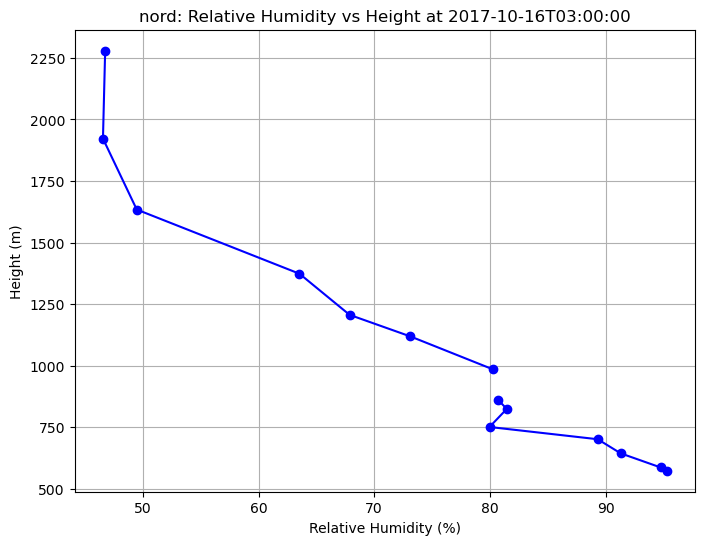

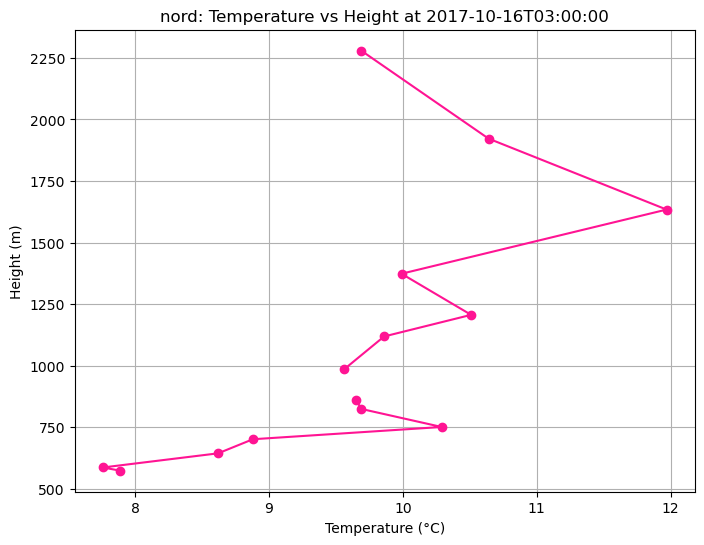

In [21]:
if __name__ == '__main__':
    selected_time = "2017-10-16T03:00:00"
    loc = "nord"
    hobos_data_sorted = read_in_hobos(loc=loc, my_time=selected_time)

    # heights
    heights = [station_data['zsl'] for station_data in hobos_data_sorted.values()]

    # Extract temperature
    temperatures = [station_data['ta'] for station_data in hobos_data_sorted.values()]

    # Relative Humidity
    rh_values = [station_data['rh'] for station_data in hobos_data_sorted.values()]

    plot_rh(rh_values, heights, selected_time)
    plot_temp(temperatures, heights, selected_time)
    # plot the locations of the HOBOS stations
    #locations_plot()
    plt.show()

In [22]:
import pandas as pd
datetime_range = pd.date_range(start='2017-10-15 14:00', end='2017-10-16 12:00', freq='H')

C:\Users\eleme\AppData\Local\Temp\ipykernel_15364\382984973.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datetime_range = pd.date_range(start='2017-10-15 14:00', end='2017-10-16 12:00', freq='H')


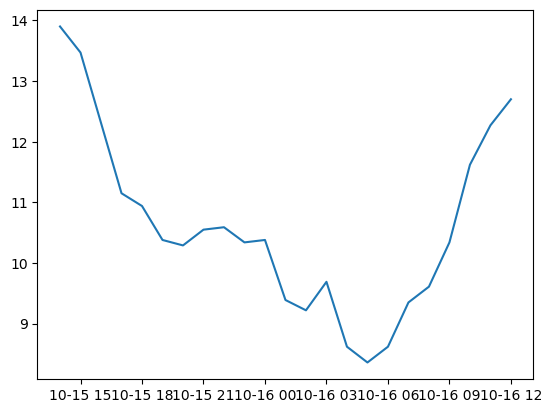

In [23]:
hobo_zeitreihe = [station_data['ta'] for station_data in read_in_hobos(loc, my_time=datetime_range).values()]
plt.plot(datetime_range, hobo_zeitreihe[0]);

In [24]:
datetime_range

DatetimeIndex(['2017-10-15 14:00:00', '2017-10-15 15:00:00',
               '2017-10-15 16:00:00', '2017-10-15 17:00:00',
               '2017-10-15 18:00:00', '2017-10-15 19:00:00',
               '2017-10-15 20:00:00', '2017-10-15 21:00:00',
               '2017-10-15 22:00:00', '2017-10-15 23:00:00',
               '2017-10-16 00:00:00', '2017-10-16 01:00:00',
               '2017-10-16 02:00:00', '2017-10-16 03:00:00',
               '2017-10-16 04:00:00', '2017-10-16 05:00:00',
               '2017-10-16 06:00:00', '2017-10-16 07:00:00',
               '2017-10-16 08:00:00', '2017-10-16 09:00:00',
               '2017-10-16 10:00:00', '2017-10-16 11:00:00',
               '2017-10-16 12:00:00'],
              dtype='datetime64[ns]', freq='h')

In [25]:
plt.plot 

<function matplotlib.pyplot.plot(*args: 'float | ArrayLike | str', scalex: 'bool' = True, scaley: 'bool' = True, data=None, **kwargs) -> 'list[Line2D]'>